In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from non_linearity.environment import Particle
from scipy import signal as sn
from scipy.optimize import curve_fit

In [2]:
omega = 2*np.pi*85e3
T = 2*np.pi/omega
t = np.arange(0, 1000*T, T/400)
N = t.shape[0]
delta_t = np.diff(t)[0]

In [3]:
200*T

0.0023529411764705885

In [4]:
gamma = 13000
env = Particle(omega, gamma)

In [5]:
def linear_force(states, t, **kwargs):
    return kwargs['gain']*states[0]


def cubic_force(states, t, **kwargs):
    return kwargs['gain']*np.power(states[0],3)


def sine_force(states, t, **kwargs):
    return kwargs['gain']*np.sin(2*np.pi*kwargs['freq']*t)

In [6]:
def simulation(env, t, force=None, delay=40, std_detection=1, **kwargs):
    states = np.array([[5],[0.]])
    N = t.shape[0]
    new_states = np.zeros((N,2)) 
    measured_states = np.zeros((N, 2))
    
    for i in range(t.shape[0]):
        new_states[i,:] = states[:,0]
        if delay <= i:
            if not force:
                control = 0
            else: 
                control = force(new_states[i-delay,:], t[i], **kwargs)
        else:
            control = 0
#        measured_states[i, :] = states[:, 0] + std_detection*np.random.normal()
        states = env.step(states, control=control, delta_t=delta_t)
    return new_states

In [7]:
M = 1
states = np.zeros((N, M))
for i in tqdm(range(M)):
    states[:,i] = simulation(env, t)[:,0]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.45s/it]


In [156]:
M = 1
cubic_states = np.zeros((N, M))
for i in tqdm(range(M)):
    cubic_states[:,i] = simulation(env, t, force=cubic_force, delay=100, gain=1e4)[:,0]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:08<00:00,  8.18s/it]


In [167]:
M = 5
damped_states = np.zeros((N, M))
for i in tqdm(range(M)):
    damped_states[:,i] = simulation(env, t, force=linear_force, delay=100, gain=0.75e4)[:,0]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:36<00:00,  7.34s/it]


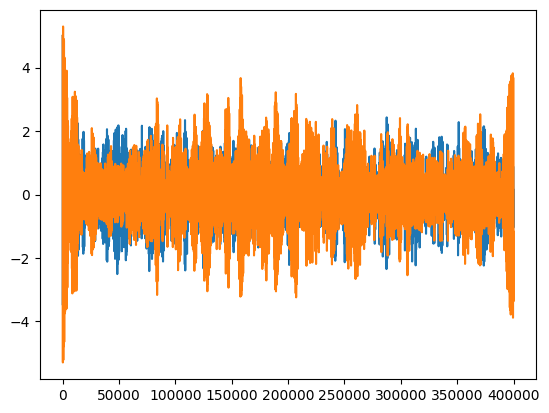

In [168]:
plt.plot(cubic_states[:,0])
plt.plot(damped_states[:,0])


In [169]:
def psd(traces, delta_t):
    pxxs = []
    for i in range(traces.shape[1]):
        freq, pxx = sn.welch(traces[:,0], fs=1/delta_t, window='hamming', nperseg=int(traces.shape[0]/3))
        pxxs.append(pxx)
    return freq, np.array(pxxs).mean(axis=0)

(20000.0, 120000.0)

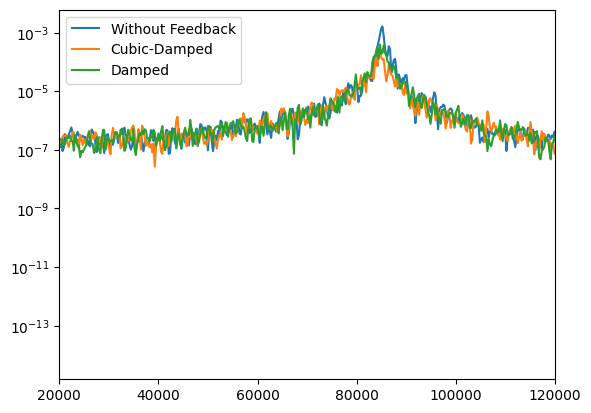

In [170]:
#freq, pxx = psd(states, delta_t)
freq, pxx = psd(states, delta_t)
freq_c, cubic_pxx = psd(cubic_states, delta_t)
freq_d, damped_pxx = psd(damped_states, delta_t)
#plt.semilogy(freq, pxx)
plt.semilogy(freq, pxx)
plt.semilogy(freq_c, cubic_pxx)
plt.semilogy(freq_d, damped_pxx)
plt.legend(['Without Feedback','Cubic-Damped', 'Damped'])
plt.xlim([2e4, 1.2e5])
#plt.ylim([1e-9, 4*max(pxx)])

In [61]:
sn.periodogram(states[:, 0], delta_t)[1].shape

(125001,)

In [68]:
freq

array([0.000000e+00, 7.200000e+02, 1.440000e+03, ..., 8.999856e+07,
       8.999928e+07, 9.000000e+07])